In [1]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2

     |████████████████████████████████| 320.4 MB 13 kB/s 
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 2.9 MB 12.3 MB/s 
     |████████████████████████████████| 5.8 MB 15.3 MB/s 
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
     |████████████████████████████████| 781 kB 12.8 MB/s 
     |████████████████████████████████| 4.9 MB 12.8 MB/s 
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.0
    Uninstalling Keras-Preprocessing-1.1.0:
      Successfully uninstalled Keras-Preprocessing-1.1.0
  Attempting uninstall: h5py
    Found existing installation: h5py 2.9.0
    Uninstalling h5py-2.9.0:
      Successfully uninstalled h5py-2.9.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorb

In [33]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import functools
import operator
from itertools import combinations
from itertools import product 
import itertools

In [88]:
UAV_capacity = 1
BS_capacity = 1
verbose = True
action_size = 1 # just placeholder, actually will be calculated later
MAX_STEPS = 5

class UAV_network(Env):   # network of UAVs not just a single one
    
    def __init__(self, n_users, coverage, name, folder_name, packet_update_loss, packet_sample_loss, periodicity): # number of total user and the user-coverage for every UAV
        
        '''
        param n_users        : int, no of users.
        param n_UAVs         : int, number of UAVs in this scenario.
        param coverage       : list of lists, each list has users covered by the drone indicated by the index of the sublist.
        param user_list      : list, user list of all users.
        param UAV_list       : list, generic UAV list. e.g. for 2 UAV [1, 2].
        param users_UAVs     : dict, will contain the users covered by each jth UAV at jth index. user_UAVs[j+1] = self.coverage[j].
        param act_coverage   : dict, same as users_UAVs but 0s removed. actual coverage.
        param BW             : int, bandwidth.
        param UAV_capacity   : int, number of users UAV can support in the uplink.
        param BS_capacity    : int, number of UAVs BS can support in the backhaul.
        user_locs            : list, locations of the users.
        grid                 : list, grid points where the UAVs can be deployed.
        UAV_loc              : list, UAV deployment positions.
        cover                : list of list, list of list containing users covered by the drone in the index position.
        UAV_age              : dict, age at UAV.
        BS_age               : dict, age at BS.
        BS_age_prev          : dict, age at BS in the previous step.
        state                : list, state of the system - contains all ages at BS and UAV.
        agent                : Object class, the DL agent that will be shared among all the UAVs.
        actions              : list, possible actions.
        action_size          : int, number of possible actions.
        current_step         : step of the ongoing episode
        episode_step         : int, current step of the ongoing episode. One episode gets over after MAX_STEP number of steps. Note difference with current_step
        preference           : dict, at each index indicated by action is an array and the array has episode wise count of how many times the action was selected. Analogous to visualizing the q-table.
        name                 : string, distinguish between eval and train networks.
        age_dist_UAV         : dict, stores the episode ending age at UAV per user.
        age_dist_BS          : dict, stores the episode ending age at BS per user.
        tx_attempt_BS        : dict, at each index indicated by user is an array and the array has episode wise count of how many times the user was updated.
        tx_attempt_UAV       : dict, at each index indicated by user is an array and the array has episode wise count of how many times the user was sampled.
        
        attempt_sample       : list, index is the episode and the value is the number of times a sample attempt was made. since each sampling results in 1 packet, this value is the number of users selected to sample
        success_sample       : list, index is episode and value is the number of sampling attempts that were successful
        
        attempt_update       : list, index is the episode and the value is the number of times a sample attempt was made. since each sampling results in 1 packet, this value is the number of users selected to sample
        success_update       : list, index is episode and value is the number of sampling attempts that were successful
        sample_time          : dict, stores the slot at which an user was sampled. To show DQN samples at periods
        
        
        '''
        
        self.n_users        = n_users
        self.periodicity    = periodicity
        self.coverage       = coverage
        self.n_UAVs         = len(coverage)
        self.UAV_capacity   = UAV_capacity
        self.BS_capacity    = BS_capacity
        self.users_UAVs     = {} # [i for i in range(1, self.n_users + 1)] # updated in start_network()
        self.act_coverage   = {} # updated in start_network()
        self.user_locs      = []
        self.grid           = []
        self.UAV_loc        = []
        self.cover          = []
        self.actions_space  = [] # initialized once the coverage is calculated
        self.action_size    = 1 # will be updated in start_network()
        self.episode_step   = 0
        self.preference     = {}
        self.current_step   = 1
        self.UAV_age        = {}
        self.BS_age         = {}
        self.BS_age_prev    = {}
        self.name           = name
        self.age_dist_UAV   = {}
        self.age_dist_BS    = {}    
        self.tx_attempt_BS  = {}
        self.tx_attempt_UAV = {}
        self.user_list      = []
        self.UAV_list       = []
        self.folder_name    = folder_name
        self.update_loss    = {} ## the dicts will be initialized in start_network
        self.sample_loss    = {}
        self.attempt_sample = []
        self.success_sample = []
        self.attempt_update = []
        self.success_update = []
        self.sample_time    = {} ## goes from 1 to MAX_STEPS inclusive in all cases
        # self.prev_action_U  = None
        # self.prev_action_S  = None
        
        
        self.start_network(packet_update_loss, packet_sample_loss)
        
        # print(f"sample_loss = {self.sample_loss}, update_loss = {self.update_loss}")

        self.action_space = Discrete(action_size)

        self.observation_space =  Box(low=0.0, high=MAX_STEPS+1, shape=(2*(n_users)+1, 1), dtype=np.int)

        self.state = np.concatenate((list([self.current_step]), [1]*2*(n_users)), axis=None) #

        # if verbose:
        # print(f"initial state is {self._state} with length {np.shape(self._state)} when CSI_as_state = {CSI_as_state} and sample_error_in_CSI = {sample_error_in_CSI}")  
              
        self._episode_ended = False
        
    def update_act_coverage(self):
        ## remove the padding from the coverage 0s so that we get the actual coverage
    
        n = [i for i in list(self.users_UAVs.keys())] # UAV ids
        k = [i for i in list(self.users_UAVs.values())] # all users
        b = {} # this will be the act_coverage

        for i in range(len(self.coverage)): # for each UAV ## don't make it UAV_list as it has not been made yet
            old_list = self.users_UAVs[i] # users under UAV i
            new_list = [j for j in old_list if j!=0] # 0s are padding not actual user. user ID cannot be 0, drone ID can be 0
            b[i] = new_list

        return b
    
    def start_network(self, packet_update_loss, packet_sample_loss):
        
        for i in range(len(self.coverage)): ## don't make it UAV_list as it has not been made yet
            self.users_UAVs[i] = self.coverage[i]
            # index of users_UAVs will start from 0
            
        self.act_coverage = self.update_act_coverage()
        # print(f"len act_coverage = {len(self.act_coverage)}")   
        self.user_list      = functools.reduce(operator.iconcat, list(self.act_coverage.values()), []) # list(self.act_coverage.values())
        self.UAV_list       = list(self.act_coverage.keys())
        
        if verbose:
            print(f"user list = {self.user_list}")
            print(f"UAV list  = {self.UAV_list}")
        
        self.update_loss    = packet_update_loss
        self.sample_loss    = packet_sample_loss
        
        for ii in self.user_list:
            self.sample_time[ii] = []


        if verbose:
            print(f'self.n_users = {self.n_users}, self.n_UAVs = {self.n_UAVs}, self.act_coverage = {self.act_coverage}, self.update_loss = {self.update_loss}, self.sample_loss = {self.sample_loss}, self.UAV_list = {self.UAV_list}, self.user_list = {self.user_list}')
            # time.sleep(15)

        self.create_action_space()

        # not doing in initialize_age() as initialize_age() is run every time net is reset so older values will be lost. start_network is run only once
        for i in self.user_list:
        
            self.age_dist_UAV[i]   = [] # ending age of every episode, updated in _reset
            self.age_dist_BS[i]    = []
            
            self.tx_attempt_BS[i]  = [] # number of attempts per episode, initialize in _reset and updated in _step
            self.tx_attempt_UAV[i] = []   
            
        for i in range(self.action_size):
            self.preference[i] = []
            
            
        if verbose:
            print(f'\n{self.name} started and age_dist_UAV = {self.age_dist_UAV}, age_dist_BS = {self.age_dist_BS}, tx_attempt_BS = {self.tx_attempt_BS}, tx_attempt_UAV = {self.tx_attempt_UAV}\n')

    
    def initialize_age(self):
        
        # before initializing, save the info    
        # for the first time it is run, BS_age and others haven't even been initialized
        
        if self.episode_step!=1: ## why !=1 ??
            
            self.attempt_sample.append(0)
            self.success_sample.append(0)
            
            self.attempt_update.append(0)
            self.success_update.append(0)
            
            
            for i in self.user_list:
                
                self.age_dist_UAV[i].append(self.UAV_age[i])
                self.age_dist_BS[i].append(self.BS_age[i])
                
                self.tx_attempt_BS[i].append(0) # 0 will be changed in _step for every attempt
                self.tx_attempt_UAV[i].append(0)
                
            for i in range(self.action_size):
                self.preference[i].append(0) 
            
            if verbose:
                print(f'\n{self.name} just before reset of {self.name} the age at UAV = {self.UAV_age}, age at BS = {self.BS_age} and these have used to update age_dist_UAV = {self.age_dist_UAV} and age_dist_BS = {self.age_dist_BS}\n')
                print(f'\n{self.name} in the same reset block, tx_attempts have been updated as tx_attempt_UAV = {self.tx_attempt_UAV} and tx_attempt_BS = {self.tx_attempt_BS}\n')
                # print(f"{self.name} preference is {self.preference}")
        
        for i in self.user_list:
            # initial age put 1 and not 0 as if 0, in first time step whethere sampled or not, all users age at UAV becomes 1 but for 1, it is different - 2 for not sampled and 1 for sampled
            self.UAV_age[i] = 1
            self.BS_age[i]  = 1
            self.BS_age_prev[i] = 1 # special case for first step ??

    def reset(self):
        self.episode_step +=1
        self.state = np.concatenate((list([self.current_step]), [1]*2*(len(self.user_list))), axis=None)
            
        self._episode_ended = False
        self.current_step = 1
        if verbose:
            print(f'\n{self.name} after reset, episode {self.episode_step} begins with self.state = {self.state} with shape {np.shape(self.state)}\n') 

        self.initialize_age()
        return self.state

        
    def map_actions(self, action):  
        '''
        convert the single integer action to specific sampling and updating tasks
        '''
        # print(f'inside  map_actions, action={action}, type(action)={type(action)}')
        # print(f'action={action},self.actions_space={self.actions_space}')
        actual_action = self.actions_space[action]
        if verbose:
            # print(f'action space is {self.actions_space}, length is {self.action_size}, array size is {len(self.actions_space)} selected action is {action} which maps to {actual_action}')
            pass
        return actual_action
    
    def get_current_state(self): # 
        state_UAV = np.array(list(self.UAV_age.values()))
        state_BS  = np.array(list(self.BS_age.values()))
        

        self.state = np.concatenate((list([self.current_step]), state_UAV, state_BS), axis=None) 

        if verbose:
            print(f'\nself._state from of {self.name} get_current_state() = {self.state} with shape = {np.shape(self._state)}\n') # debug
        return (self.state)
    
    def create_action_space(self):
        '''
        for 1 UAV once the coverage has been decided, create the action space
        2 data structures needed, a dict for storing sampling possibility at each UAV and a list to store the updating possibility
        '''
        
        update_user_possibilities = []

        if len(self.user_list) < self.BS_capacity: ## number of users available < number of users BS can update at anytime
            update_user_possibilities = list(combinations(self.user_list, len(self.user_list)))
        else:
            update_user_possibilities = list(combinations(self.user_list, self.BS_capacity)) # different combination of selecting UAVs to update
        if verbose:
            print(f"self.user_list = {self.user_list}, self.BS_capacity = {self.BS_capacity}, update_user_possibilities = {update_user_possibilities} with length {len(update_user_possibilities)}")
        
        update_user_possibilities = [list(i) for i in update_user_possibilities]
        
        ## update action part done
        sampling_choices = {}
        ##a dict with all combinations of sampling UAV_capacity users from each UAV irrespective of which UAV got updated
        for x in self.UAV_list:
            sampling_choices[x] = []
        
        for k in self.UAV_list:
            if len(self.act_coverage[k]) < self.UAV_capacity:
                sampling_choices[k].extend(list(combinations(self.act_coverage[k], len(self.act_coverage[k]))))
                # sampling_choices.extend(sampling_choice)
                
            else:
                sampling_choice = list(combinations(self.act_coverage[k], self.UAV_capacity))
                sampling_choices[k].extend(sampling_choice)
                # if verbose:
                #     print(f"users covered under UAV k are {self.act_coverage[k]}, sampling_choice = {sampling_choice}, and sampling choices has become {sampling_choices}")

        all_user_sampling_combinations = []
        for p in itertools.product(*sampling_choices.values()):
            y = [yy for zz in p for yy in zz]
            all_user_sampling_combinations.append(y)
                   

        actions_space = list(itertools.product(update_user_possibilities, all_user_sampling_combinations))
        
        actions_space = [list(i) for i in actions_space]
            
        if verbose:
            print(f"sampling_choices = {sampling_choices} with length = {len(sampling_choices)} and \nall_user_sampling_combinations is {all_user_sampling_combinations} with length {len(all_user_sampling_combinations)}")
            print("\naction_size is ", len(actions_space)) #, " and they are actions_space = ", actions_space)
            # time.sleep(10)
            
            
        self.actions_space = actions_space
        self.action_size = len(self.actions_space)
        
        if verbose:
            print(f"\n{self.name} has a action_space of size ", np.shape(self.actions_space)) #, " and they are ", self.actions_space,  "\n")
            # time.sleep(10)
            
        # print("\n action_space is of size ", np.shape(self.actions_space), file = open(self.folder_name + "/results.txt", "a"))
        # print("\n action_space is of size ", np.shape(self.actions_space), " and they are ", self.actions_space)
    
    def step(self, action):
                  
        if self._episode_ended:
            if verbose:
                print(f'for {self.name}, episode = {self.episode_step} at first reset')
            return self.reset()
        actual_action = self.map_actions(action)
        print(f"actual_action={actual_action}, action={action}")
        # action = action.tolist()

        # print(f"\n env = {self.name}, self.current_step = {self.current_step}, self.episode_step = {self.episode_step}, action = {action}, type(action) = {type(action)}, (actual_action)={actual_action}, preference = {self.preference}") #, {type(self.preference[action])}") ## for some reason action is type nparray
        # self.preference[action][-1] = self.preference[action][-1] + 1
            
        # updated_UAVs  = list(actual_action[0])
        updated_users = list(actual_action[0])
        # for j in updated_UAVs:
        #     updated_users.extend(self.act_coverage[j])
        sampled_users = list(actual_action[1])
        if verbose:
        
            print(f'\nfor {self.name}, current_step = {self.current_step}, selected action = {action}, actual_dqn_action={actual_action}, updated_users = {updated_users} sampled_users={sampled_users}\n') 
            # time.sleep(3)
            
            print(f"{self.name} tx_attempt_BS was {self.tx_attempt_BS}")
        
        if self.current_step==1: ## updating
        # step 1 so BS has nothing to get from UAV
            for i in self.user_list:
                self.BS_age[i] = self.BS_age[i]+1

        else: # not time step = 1
            for i in self.user_list: ## updating
                if i in updated_users:
                    ## find associated UAV
                    for kk in self.act_coverage:
                        if i in self.act_coverage[kk]:
                            associated_UAV = kk
                    ##
                    self.tx_attempt_BS[i][-1] = self.tx_attempt_BS[i][-1] + 1
                    self.attempt_update[-1] = self.attempt_update[-1] + 1
                    chance_update_loss = np.round(random.random(), 2)
                    if verbose:
                    #     print(f"user {i}'s associated UAV is {associated_UAV}")
                        print(f"for user {i}, chance_update_loss = {chance_update_loss} and {self.name}.update_loss = {self.update_loss[i]} ")
                    if chance_update_loss > self.update_loss[i]:
                        if verbose:
                            print("user ", i, " was updated")
                        self.BS_age[i] = self.UAV_age[i] + 1 # age for the next slot, like how I update current_sample in my SWIFT work
                        self.success_update[-1] = self.success_update[-1] + 1
                    else:
                        self.BS_age[i] = self.BS_age[i] + 1
                        if verbose:
                            print(f'user {i} was updated but had update failure')
                            
                else:
                    if verbose:
                        print("user ", i, " was not updated")
                    self.BS_age[i] = self.BS_age[i] + 1
                
        
        if verbose:
            print(f"{self.name} tx_attempt_BS has become {self.tx_attempt_BS}")
            ## for first step, even if some user was updated, it is not counted in the tx_attempt_BS as that tx has no role in minimizing AoI. Therefore for a scenario with 4 steps, tx_attempt_UAV will go to max 4 but tx_attempt_BS will go to 3 as only 3 attempts are counted
            print(f"{self.name} tx_attempt_UAV was {self.tx_attempt_UAV}")

        for i in self.user_list: ## sampling
            if i in sampled_users:
                self.sample_time[i].append(self.current_step)
                chance_sample_loss = np.round(random.random(), 2)
                self.tx_attempt_UAV[i][-1] = self.tx_attempt_UAV[i][-1] + 1
                self.attempt_sample[-1] = self.attempt_sample[-1] + 1
                if verbose:
                    print(f" for user {i}, chance_sample_loss = {chance_sample_loss} and self.sample_loss = {self.sample_loss[i]} ")
                if chance_sample_loss > self.sample_loss[i]:
                    if (self.current_step-1)%self.periodicity[i]==0: ## -1 as here time starts from 1
                        if verbose:
                            print("slot = ", self.current_step-1, " - user ", i, " period = ", self.periodicity[i], " was selected to sample and sampled")
                        self.UAV_age[i] = 1 # age for the next slot, like how I update current_sample in my SWIFT work
                        self.success_sample[-1] = self.success_sample[-1] + 1
                    else:
                        if verbose:
                            print("slot = ", self.current_step-1, " - user ", i, " period = ", self.periodicity[i], " was selected to sample but not sampled")                    
                else:
                    self.UAV_age[i] = self.UAV_age[i] + 1
                    if verbose:
                        print(f'user {i} was sampled but had sample failure')
                        
                    
            else:
                if verbose:
                    print("user ", i, " was not sampled")
                self.UAV_age[i] = self.UAV_age[i] + 1
        
        # print(f"slot {self.current_step} ended with state {self._state}")        
                
        if verbose:
            print(f"time = {self.current_step}, sample_time = {self.sample_time}")
            print(f"{self.name} tx_attempt_UAV has become {self.tx_attempt_UAV}")
            # time.sleep(10)

                
        self._state = self.get_current_state() # update state after every action
        
       
        BS_sum_age = np.sum(list(self.BS_age.values()))
        
        self.current_step += 1
        
        award = -BS_sum_age
        
        
        # if verbose:
        #     print(f"attempt_sample = {self.attempt_sample}")
        #     print(f"success_sample = {self.success_sample}")
        #     print(f"attempt_update = {self.attempt_update}")
        #     print(f"success_update = {self.success_update}")
        #     time.sleep(5)
                   
        
        if verbose:
            print(f'new current_step = {self.current_step}')
            print(f"{self.name} tx_attempt_UAV has become {self.tx_attempt_UAV}")
            print(f"new state is {self.get_current_state()}")
            print(f'\nfor {self.name}, award is {award}\n') # debug
            # time.sleep(10)

        info = {}

        if self.current_step < MAX_STEPS + 1:        ## has to run for MAX_STEPS, i.e. an action has to be chosen MAX_STEPS times
            done = False
            return self.state, award, done, info
        else:
            # print(f'in terminate block') # will also reset the environment
            done = True
            # time_step.is_last() = True
            return self.state, award, done, info

In [89]:
env = UAV_network(3, {0:[1,2,3]}, "UAV_network", "None", {1:0,2:0,3:0}, {1:0,2:0,3:0}, {1:2,2:1,3:1})

user list = [1, 2, 3]
UAV list  = [0]
self.n_users = 3, self.n_UAVs = 1, self.act_coverage = {0: [1, 2, 3]}, self.update_loss = {1: 0, 2: 0, 3: 0}, self.sample_loss = {1: 0, 2: 0, 3: 0}, self.UAV_list = [0], self.user_list = [1, 2, 3]
self.user_list = [1, 2, 3], self.BS_capacity = 1, update_user_possibilities = [(1,), (2,), (3,)] with length 3
sampling_choices = {0: [(1,), (2,), (3,)]} with length = 1 and 
all_user_sampling_combinations is [[1], [2], [3]] with length 3

action_size is  9

UAV_network has a action_space of size  (9, 2, 1)

UAV_network started and age_dist_UAV = {1: [], 2: [], 3: []}, age_dist_BS = {1: [], 2: [], 3: []}, tx_attempt_BS = {1: [], 2: [], 3: []}, tx_attempt_UAV = {1: [], 2: [], 3: []}



In [90]:
env.observation_space.sample()

array([[5],
       [3],
       [5],
       [0],
       [4],
       [1],
       [6]])

In [87]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        #env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))


UAV_network after reset, episode 1 begins with self.state = [1 1 1 1 1 1 1] with shape (7,)

actual_action=[[1], [1]], action=0

for UAV_network, current_step = 1, selected action = 0, actual_dqn_action=[[1], [1]], updated_users = [1] sampled_users=[1]

UAV_network tx_attempt_BS was {1: [], 2: [], 3: []}
UAV_network tx_attempt_BS has become {1: [], 2: [], 3: []}
UAV_network tx_attempt_UAV was {1: [], 2: [], 3: []}


IndexError: list index out of range

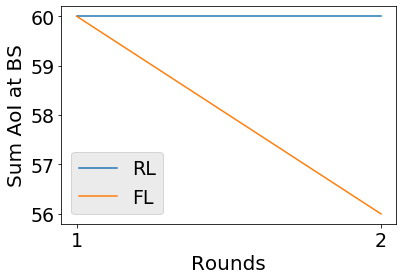

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import random

# from create_graph_1 import *
import pickle


path = "/home/biplav/AoI/AoI-FL-UAV_ver1/runs/2021-11-22_10-44-39/"
path_RL = path + "rl/"
path_FL = path + "fl/"


rl_returns_dict = pickle.load(open(path_RL + "rl_returns.pickle", "rb"))
fl_returns_dict = pickle.load(open(path_FL + "fl_returns.pickle", "rb"))

rounds_list = sorted(rl_returns_dict.keys())

eval_results_list_rl = []
eval_results_list_fl = []

for round in rounds_list:
    eval_results_list_rl.append(-1*np.mean(rl_returns_dict[round]["eval"]["rewards"]))
    eval_results_list_fl.append(-1*np.mean(fl_returns_dict[round]["eval"]["rewards"]))

fig, ax1 = plt.subplots()
ax1.plot(rounds_list, eval_results_list_rl, label = "RL")
ax1.plot(rounds_list, eval_results_list_fl, label = "FL")

ax1.legend()

ax1.tick_params(axis='x', labelsize=19)
ax1.tick_params(axis='y', labelsize=19)
legend = ax1.legend(loc='best', shadow=False, fontsize='19')

legend.get_frame().set_facecolor('0.90')
plt.show
plt.xlabel('Rounds', fontsize='20')
plt.ylabel('Sum AoI at BS', fontsize='20')
plt.savefig(path + 'result.png', bbox_inches='tight')